# Computer Vision Assignment
In this assignment you will be required to create a CV classifier on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. To achieve this you will be required to create and compare different classifier. More precisely you will be asked to:

*   Create the right data-loading pipeline (e.g., Data augmentation, batch size, loading strategy, etc.)
*   Select the proper transfer learning strategy (e.g., fine-tuning, transfer learning, training from scratch) 
*   Select the right hyperparameters (e.g., learning rate, optimizer)

More importantly, you are required to **explain** the choices that you make. To do so, you can also perform different experiments (e.g., comparing two different learning rates or transfer learning strategies) and provide a comment on why one perform better than the other at the end of the notebook. 
You can re-use the notebook that we have been using in the classroom.

You are only provided with:


*   The dataset (directly provided by Torchvision)
*   The neural architecture: a Resnet18 `network = torchvision.models.resnet18()`






In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
from assignment_utils import *
%reload_ext autoreload
%autoreload 2

cudnn.benchmark = True
plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda:0


## Loading Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify ten different objects: *airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck*. We have 50000 training images and 10000 validation images.

We can directly load the dataset from its torchvision class.

In [14]:
data = Data()
pred = Prediction()

Files already downloaded and verified
Files already downloaded and verified
Train size: 50000
Val size: 10000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Now we have to create the dataloader, as we in the previous lab for the logistic regression. Notice however that we are using one more parameter:

*   ``num_workers`` is used to *parallelize* the loading from disk. 

Indeed, image datasets are too big normally to fit in memory and images are loaded from disk at every batch. In this case we do that using 4 threads to load the 16 images in parallel (4 per thread). 


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



In [15]:
data.imshow_train_val(num_img=4)

## Select and compare different transfer - learning strategy

You need to compare the 3 learning strategy and comment the results obtained:

- Transfer Learning (remember to directly extract the features!)
- Fine tuning
- Training from scratch

Start simple! Traning from scratch may be very expensive with this dataset since we have 50000 images.

Also, to ensure that your code is working, you can use `torch.data.Subset(dataset, indexes)` to use a smaller version of the dataset


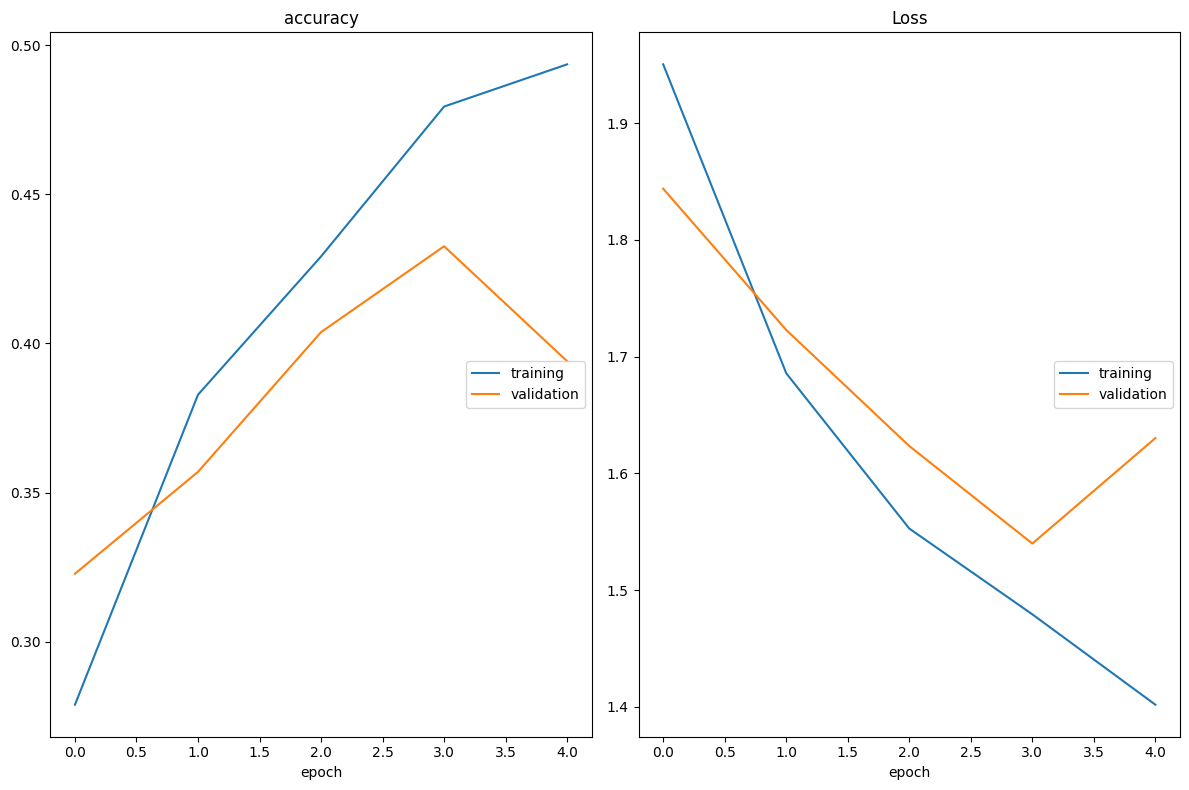

accuracy
	training         	 (min:    0.279, max:    0.494, cur:    0.494)
	validation       	 (min:    0.323, max:    0.433, cur:    0.394)
Loss
	training         	 (min:    1.402, max:    1.950, cur:    1.402)
	validation       	 (min:    1.540, max:    1.844, cur:    1.630)
Epoch 5/49
----------


KeyboardInterrupt: 

In [16]:
num_classes = 10
lr = 1e-4
max_lr = 0.01
# grad_clip = 0.1
weight_decay = 1e-4


# Model
model = torchvision.models.resnet18(num_classes=num_classes).to(DEVICE)

# Loss
loss = F.cross_entropy

# Optimizer
opt = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=weight_decay)

# Function
model = pred.train_model(
  model=model,
  train_dl=data.train_dl,
  val_dl=data.val_dl,
  loss=loss,
  optim=opt,
  num_epochs=50,
)


## Select and compare hyperparameters
Once you found the best transfer learning strategy, I want you to find the best hyperparameters: 


*   Learning Rate
*   Data augmentation
*   Optional: optimizer, batch size, etc.




In [83]:
## FILL IT YOURSELF

## Evaluation of the assignment
The evaluation of the assignment will be based on 3 different aspects:

*   Percentage of assignment completed (50 % of the grade)
*   Correctness of the comments used to explain the result (40% of the grade)
*   Validation accuracy of the final model provided (10 % of the grade)

